In [ ]:
# Import neccessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import nltk
import numpy as np
import pandas as pd
import re


In [ ]:
# Testing if GPU is active
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Import Data from url
!wget https://raw.githubusercontent.com/Niger-Volta-LTI/yoruba-text/master/Owe/owe.txt

--2022-09-06 16:37:01--  https://raw.githubusercontent.com/Niger-Volta-LTI/yoruba-text/master/Owe/owe.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180836 (177K) [text/plain]
Saving to: ‘owe.txt’

owe.txt             100%[===================>] 176.60K  --.-KB/s    in 0.02s   

2022-09-06 16:37:01 (7.98 MB/s) - ‘owe.txt’ saved [180836/180836]



In [ ]:
# Load data
with open("owe.txt", "r") as file:
  data = file.readlines()
  # using regular expression to remove punctuations from each line
  data = re.sub(r"[^\w\s]","",''.join(data)).lower().split('\n')
  #data = ''.join(data).lower().split('\n')
del data[0]
del data[-1]
print(len(data))
data[:2]

2700


['a di gàárì sílẹ ewúrẹ ńyọjú ẹrù ìran rẹ ni',
 'a kì í dàgbà má làáyà ibi ayé bá báni là ńjẹ ẹ']

## Data Preprocessing(Removing Stopwords, Tokenization, Sequencing and Sequence Padding)

In [ ]:
df = pd.DataFrame(data, columns=['owe'])
df.head()

,owe
0,a di gàárì sílẹ ewúrẹ ńyọjú ẹrù ìran rẹ ni
1,a kì í dàgbà má làáyà ibi ayé bá báni là ńjẹ ẹ
2,àgbà kán ṣe bẹẹ lógùn yemaja ló gbé e lọ
3,ibi tí oyín gbé ńhó tí àdó ńhó ìfun ò dákẹ lásán
4,ìdí òwò ni òwòó gbé tà


In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
# Function for text cleaning
def clean_text(text):
    # Remove english stop words
    stop_words = set(stopwords.words('english'))
    cleaned_text = ' '.join([w for w in text.split() if  not w in stop_words])
    return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['clean_owe'] = df['owe'].apply(clean_text)

In [ ]:
# convert column to a list of each row
data = [line for line in df['clean_owe']]

In [ ]:
# Instantiating tokenizer
tokenizer = Tokenizer()

# Assigning a new variable name to data
corpus = data

# Create tokens of each words as a dictionary with key being word and the value beings its token
tokenizer.fit_on_texts(corpus)

#calculating total number of words in the data
total_words = len(tokenizer.word_index) + 1

print(total_words)
print(tokenizer.word_index)


5099
{'ní': 1, 'ò': 2, 'í': 3, 'kì': 4, 'ó': 5, 'bí': 6, 'bá': 7, 'tí': 8, 'tó': 9, 'ẹni': 10, 'fi': 11, 'kò': 12, 'ni': 13, 'jẹ': 14, 'ṣe': 15, 'ká': 16, 'ẹ': 17, 'mọ': 18, 'kí': 19, 'là': 20, 'ti': 21, 'kó': 22, 'rẹ': 23, 'yó': 24, 'òun': 25, 'lọ': 26, 'sí': 27, 'rí': 28, 'ló': 29, 'á': 30, 'ọmọ': 31, 'ojú': 32, 'pa': 33, 'wọn': 34, 'lè': 35, 'ohun': 36, 'gbé': 37, 'à': 38, 'má': 39, 'fún': 40, 'pé': 41, 'la': 42, 'ọ': 43, 'máa': 44, 'tán': 45, 'ta': 46, 'wá': 47, 'kan': 48, 'sọ': 49, 'kú': 50, 'mú': 51, 'ilé': 52, 'ara': 53, 'ẹní': 54, 'àgbà': 55, 'ńjẹ': 56, 'ọjọ': 57, 'ajá': 58, 'di': 59, 'ibi': 60, 'kọ': 61, 'baba': 62, 'bọ': 63, 'ọlẹ': 64, 'èèyàn': 65, 'fẹ': 66, 'orí': 67, 'adìẹ': 68, 'gbọ': 69, 'mi': 70, 'ńṣe': 71, 'lójú': 72, 'ọwọ': 73, 'ńpa': 74, 'ọràn': 75, 'lọwọ': 76, 'ọmọdé': 77, 'òún': 78, 'ṣéé': 79, 'sílẹ': 80, 'wo': 81, 'gba': 82, 'gbogbo': 83, 'dá': 84, 'mo': 85, 'ju': 86, 'ọrọ': 87, 'bó': 88, 'mí': 89, 'gbà': 90, 'oko': 91, 'inú': 92, 'gbọn': 93, 'ẹnu': 94, 'dé': 95, '

In [ ]:
# Training features
input_sequences = []

for line in corpus:
  # Converts each sentence as its tokenized equivalent
  token_list = tokenizer.texts_to_sequences([line])[0]
  
  for i in range(1,len(token_list)):
    #generating n_gram sequences: 1st two words in the token_list is one sequence, next two words are another sequence and so on
      n_gram_sequence = token_list[:i+1]
      #appending each n_gram sequence to the list of our features
      input_sequences.append(n_gram_sequence)
print("The training features are:\n",input_sequences)

The training features are:
 [[59, 1276], [59, 1276, 80], [59, 1276, 80, 188], [59, 1276, 80, 188, 910], [59, 1276, 80, 188, 910, 119], [59, 1276, 80, 188, 910, 119, 722], [59, 1276, 80, 188, 910, 119, 722, 23], [59, 1276, 80, 188, 910, 119, 722, 23, 13], [4, 3], [4, 3, 318], [4, 3, 318, 39], [4, 3, 318, 39, 2040], [4, 3, 318, 39, 2040, 60], [4, 3, 318, 39, 2040, 60, 136], [4, 3, 318, 39, 2040, 60, 136, 7], [4, 3, 318, 39, 2040, 60, 136, 7, 319], [4, 3, 318, 39, 2040, 60, 136, 7, 319, 20], [4, 3, 318, 39, 2040, 60, 136, 7, 319, 20, 56], [4, 3, 318, 39, 2040, 60, 136, 7, 319, 20, 56, 17], [55, 492], [55, 492, 15], [55, 492, 15, 164], [55, 492, 15, 164, 2041], [55, 492, 15, 164, 2041, 2042], [55, 492, 15, 164, 2041, 2042, 29], [55, 492, 15, 164, 2041, 2042, 29, 37], [55, 492, 15, 164, 2041, 2042, 29, 37, 165], [55, 492, 15, 164, 2041, 2042, 29, 37, 165, 26], [60, 8], [60, 8, 2043], [60, 8, 2043, 37], [60, 8, 2043, 37, 911], [60, 8, 2043, 37, 911, 8], [60, 8, 2043, 37, 911, 8, 493], [60, 8

## 'Pre' padding the sequences with '0' to bring them to equal array length

In [ ]:
# Calculating the length of the longest sequence in our training features
max_sequence_len = max([len(x) for x in input_sequences])

#pre-pading each value of the input_sequence
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len,padding='pre'))
print(input_sequences)

[[   0    0    0 ...    0   59 1276]
 [   0    0    0 ...   59 1276   80]
 [   0    0    0 ... 1276   80  188]
 ...
 [   0    0    0 ...   29   21  208]
 [   0    0    0 ...   21  208   30]
 [   0    0    0 ...  208   30   45]]


In [ ]:
# Create predictors and label using numpy slicing
features = input_sequences[:,:-1]
labels = input_sequences[:,-1]

# Creating one hot encoding values of each labels 
labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Modelling

**PS: One rule of thumb is that the embedding dimension should be approximately 1.6 times the square root of the number of unique elements in the category**

In [ ]:
# Set embedding dimension for embedding layer
output_dim = int(np.sqrt(total_words) * 1.6)

In [ ]:
# Creating a sequential model
model = Sequential()
# Adding an embedding layer with 64 as the embedding dimension
model.add(Embedding(total_words, output_dim=output_dim, input_length=max_sequence_len - 1))
# Adding 400 LSTM units
model.add(Bidirectional(LSTM(400)))
# Creating a dense layer with 5099 output units (total_words) with softmax activation
model.add(Dense(total_words, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 114)           581286    
                                                                 
 bidirectional (Bidirectiona  (None, 800)              1648000   
 l)                                                              
                                                                 
 dense (Dense)               (None, 5099)              4084299   
                                                                 
Total params: 6,313,585
Trainable params: 6,313,585
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling the model with adam optimiser
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# Training for 500 epochs
history = model.fit(features,labels,epochs=500,verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/500
732/732 [==============================] - 18s 14ms/step - loss: 8.0131 - accuracy: 0.0521
Epoch 2/500
732/732 [==============================] - 10s 14ms/step - loss: 6.3412 - accuracy: 0.0963
Epoch 3/500
732/732 [==============================] - 10s 14ms/step - loss: 5.4715 - accuracy: 0.1342
Epoch 4/500
732/732 [==============================] - 10s 14ms/step - loss: 4.5569 - accuracy: 0.1824
Epoch 5/500
732/732 [==============================] - 11s 14ms/step - loss: 3.5866 - accuracy: 0.2749
Epoch 6/500
732/732 [==============================] - 11s 14ms/step - loss: 2.7444 - accuracy: 0.4059
Epoch 7/500
732/732 [==============================] - 11s 15ms/step - loss: 2.1314 - accuracy: 0.5164
Epoch 8/500
732/732 [==============================] - 11s 15ms/step - loss: 1.7300 - accuracy: 0.5947
Epoch 9/500
732/732 [==============================] - 11s 15ms/step - loss: 1.4850 - accuracy: 0.6470
Epoch 10/500
732/732 [==============================] - 11s 14ms/step - l

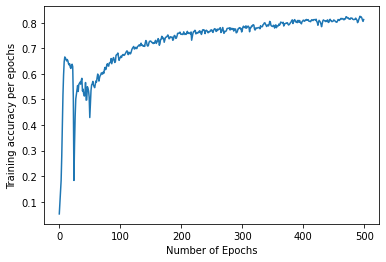

In [ ]:
#plotting the training accuracy of the model
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.xlabel("Number of Epochs")
plt.ylabel('Training accuracy per epochs')
plt.show()

## Text Prediction. A seed text to start the predicted proverbs is preprocessed exactly as the training data is 

In [ ]:
def generate_proverbs(seed_text,next_words):
    """ A function that takes a 
    seed_text: to prompt next word prediction
    next_word: The number of next words to predict
    and returns the predicted yoruba proverbs"""
    for _ in range(next_words):
       # Converting our seed_text to tokens and excluding the out of vocabulary words
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # Padding the seed_text
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
        # Predicting the token of the next word using our trained model
        predicted = model.predict(token_list, verbose=0)
        classes=np.argmax(predicted,axis=1)
        # Assigning empty string to output word 
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == classes:
              # Convert the token back to the corresponding word and storing it in the output_word
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

## Generate yoruba proverbs

In [ ]:
data[34:38]

['ìṣeǹṣe ewúrẹ kágùntàn fiyè síi',
 'àgbà kì í ṣorò bí èwe',
 'iṣú ta iṣu ò ta ọkọọkan là ńwúṣu lébè',
 'ìtórò tó lóko tí kò fẹhìntì afẹfẹ oko ní ńtú u']

In [ ]:
generate_proverbs('obinrin',10)

'obinrin ọmọ ẹni ẹlẹni ò jọ ọmọ ẹni ọmọ eni ìbá'

In [ ]:
generate_proverbs('àtẹnumọ',15)

'àtẹnumọ kì í mẹrẹ àwòdì kì í gbọ lù ú lẹnu àgbà kì í gbọ ègùn'

In [ ]:
alist = ['ńwúṣu','àgbà','ewúrẹ']
for word in alist:
  print(generate_proverbs(word,10))

ńwúṣu kì í lọ ọ kú sóko ìwájẹ fi ṣe bí
àgbà ajá kì í bàwọjẹ kì í ṣe bí ọba àrà
ewúrẹ ò ṣee fiṣu ṣọ ojúlé ńdá iná ò tó ṣe


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
##How to save and load the model with tf.keras
model.save("/content/gdrive/My Drive/yoruba_proverbs_generator_model_lstm_400b.h5")
model = tf.keras.models.load_model('/content/gdrive/My Drive/yoruba_proverbs_generator_model_lstm_400b.h5')

In [ ]:
# Reset model 
from keras import backend as K
del model
K.clear_session()
tf.compat.v1.reset_default_graph()

In [ ]:
# import joblib
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
# import numpy as np
# import pandas as pd
# import re
# import nltk

# Load data
with open("owe.txt", "r", encoding="utf-8") as file:
    data = file.readlines()
  # using regular expression to remove punctuations from each line
    data = re.sub(r"[^\w\s]","",''.join(data)).lower().split('\n')
del data[0]
del data[-1]

df = pd.DataFrame(data, columns=['owe'])
df.head()

nltk.download('stopwords')
from nltk.corpus import stopwords
# Function for text cleaning
def clean_text(text):
    # Remove english stop words
    stop_words = set(stopwords.words('english'))
    cleaned_text = ' '.join([w for w in text.split() if  not w in stop_words])
    return cleaned_text
df['clean_owe'] = df['owe'].apply(clean_text)
# convert column to a list of each row
data = [line for line in df['clean_owe']]

tokenizer = Tokenizer()
corpus = data
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1,len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len,padding='pre'))

model = tf.keras.models.load_model('/content/gdrive/My Drive/yoruba_proverbs_generator_model_lstm_400b.h5')

def generate_proverbs(seed_text,next_words):
    """ A function that takes a 
    seed_text: to prompt next word prediction
    next_word: The number of next words to predict
    and returns the predicted yoruba proverbs"""
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        classes=np.argmax(predicted,axis=1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == classes:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
generate_proverbs('ìkokò', 10)

'ìkokò ajá kì í ṣe bẹẹ rí ẹ lọrun sọnù kò'

CHallenges
How to diacritize yoruba